In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import utils
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
def filter_by_prefix(df,prefix):
    '''
    Filter case by prefix length
    
    Parameters
    ----------
    df : pandas dataframe
        Assigned dataframe to slice by prefix length
    
    prefix : int
        Prefix length to slice to cases in fixed length
    
    Returns
    ----------
    Return dataframe with sliced cases
    '''
    df['ts'] = pd.to_datetime(df['ts'])
    groups = df.groupby('caseid')
    encoded_df=[]
    for case,group in groups: 
        group = group.reset_index(drop=True)
        if len(group)>=prefix:
            group = group.loc[:prefix-1,:]
            encoded_df.append(group)
    return pd.concat(encoded_df)

In [3]:
def aggregation_encoding(df, prefix):
    '''
    Aggregation encoding
    
    Parameters
    ----------
    df : pandas dataframe
        Assigned dataframe to encode for outcome prediction
    
    prefix : int
        Prefix length to slice to cases in fixed length
    
    Returns
    ----------
    Return dataframe encoded in aggregation method
    '''
    df = filter_by_prefix(df,prefix)
    df['ts'] = pd.to_datetime(df['ts'])
    groups = df.groupby('caseid')
    encoded_df=[]
    for case,group in groups: 
        group = group.reset_index(drop=True)
        outcome = set(group['outcome']).pop()
        cumdurationlist = [(x - list(group['ts'])[0]).total_seconds() for x in list(group['ts'])]
        case_time_outcome = {'caseid':case, 'ts':np.mean(cumdurationlist),'outcome':outcome}
        activity_count = {x: list(group['activity']).count(x) for x in set(group['activity'])}
        resource_count = {x: list(group['resource']).count(x) for x in set(group['resource'])}

        case_time_outcome.update(activity_count)
        case_time_outcome.update(resource_count)
        dfk = pd.DataFrame.from_dict([case_time_outcome])
        encoded_df.append(dfk)
    concated_df = pd.concat(encoded_df)
    concated_df = concated_df.fillna(0)
    return concated_df

In [4]:
df = pd.read_csv('./data/bpic2017.csv')
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])
df = df.rename(columns={'Case ID':'caseid','Activity':'activity','Complete Timestamp':'ts','Resource':'resource'})
df = df.loc[:,['caseid','activity','ts','resource']]
groups = df.groupby('caseid')
reconcatenate =[]
for _,group in groups:
    group = group.reset_index(drop=True)
    case_label = utils.set_label(group.iloc[-1,:].to_dict())['True label']
    group.loc[:,'outcome'] = case_label
    reconcatenate.append(group)
dfn = pd.concat(reconcatenate)
df2 = aggregation_encoding(dfn,2)
df3 = aggregation_encoding(dfn,3)
df4 = aggregation_encoding(dfn,4)

In [5]:
print('BPIC2017 aggregation encoding with prefix length 3')
y = df3['outcome']
x =df3.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 aggregation encoding with prefix length 3
Decision Tree
              precision    recall  f1-score   support

    Accepted       0.47      0.06      0.10       579
   Cancelled       0.51      0.96      0.67       761
     Refused       0.00      0.00      0.00       160

    accuracy                           0.51      1500
   macro avg       0.33      0.34      0.26      1500
weighted avg       0.44      0.51      0.38      1500



/home/iel03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iel03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iel03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
print('BPIC2017 aggregation encoding with prefix length 4')
y = df4['outcome']
x =df4.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 aggregation encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

    Accepted       0.75      1.00      0.85       570
   Cancelled       1.00      0.88      0.94       732
     Refused       1.00      0.31      0.47       157

    accuracy                           0.87      1459
   macro avg       0.91      0.73      0.75      1459
weighted avg       0.90      0.87      0.85      1459



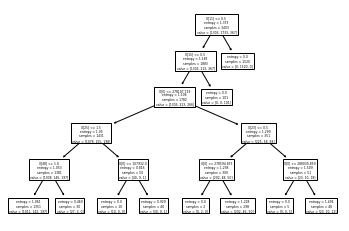

In [10]:
tree.plot_tree(dt)
# plt.show()
plt.savefig('./img/offlinetree.png',dpi=300)